# Système de Détection de Spam

## 1. Importation des bibliothèques

In [20]:
# Bibliothèques de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP et preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Visualisation
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Sauvegarde du modèle
import joblib

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Toutes les bibliothèques ont été importées avec succès!')

Toutes les bibliothèques ont été importées avec succès!


[nltk_data] Downloading package punkt to /home/simo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/simo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Chargement et Exploration des Données

In [2]:
# Chargement du dataset
df = pd.read_csv('DataSet_Emails.csv')

print(f"Dataset chargé avec succès!")
print(f"Dimensions: {df.shape}")
print(f"\nPremières lignes du dataset:")
df.head()

Dataset chargé avec succès!
Dimensions: (31716, 8)

Premières lignes du dataset:


,Unnamed: 0,message_id,text,label,label_text,subject,message,date
0,0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


In [3]:
df = df.drop("Unnamed: 0", axis=1)

### 2.1 Structure du Dataset

In [4]:
# Informations sur le dataset
print("=" * 60)
print("INFORMATIONS SUR LE DATASET")
print("=" * 60)
print(f"\nNombre total d'emails: {len(df)}")
print(f"\nNombre de colonnes: {len(df.columns)}")
print(f"\nNoms des colonnes: {list(df.columns)}")
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nAperçu statistique:")
df.info()

INFORMATIONS SUR LE DATASET

Nombre total d'emails: 31716

Nombre de colonnes: 7

Noms des colonnes: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date']

Types de données:
message_id     int64
text          object
label          int64
label_text    object
subject       object
message       object
date          object
dtype: object

Aperçu statistique:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31716 entries, 0 to 31715
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message_id  31716 non-null  int64 
 1   text        31665 non-null  object
 2   label       31716 non-null  int64 
 3   label_text  31716 non-null  object
 4   subject     31442 non-null  object
 5   message     31371 non-null  object
 6   date        31716 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


### 2.2 Détection des valeurs manquantes et doublons

In [5]:
print("=" * 60)
print("ANALYSE DES VALEURS MANQUANTES ET DOUBLONS")
print("=" * 60)

# Valeurs manquantes
print("\nValeurs manquantes par colonne:")
print(df.isnull().sum())
print(f"\nPourcentage de valeurs manquantes:")
print(df.isnull().sum() / len(df) * 100)

# Doublons basés sur le contenu du texte
duplicates = df.duplicated(subset=['text']).sum()
print(f"\nNombre de doublons: {duplicates}")
print(f"Pourcentage de doublons: {duplicates / len(df) * 100:.2f}%")

if duplicates > 0:
    print(f"\nExemples de lignes dupliquées:")
    print(df[df.duplicated(subset=['text'], keep='first')].head(10))

ANALYSE DES VALEURS MANQUANTES ET DOUBLONS

Valeurs manquantes par colonne:
message_id      0
text           51
label           0
label_text      0
subject       274
message       345
date            0
dtype: int64

Pourcentage de valeurs manquantes:
message_id    0.000000
text          0.160802
label         0.000000
label_text    0.000000
subject       0.863917
message       1.087779
date          0.000000
dtype: float64

Nombre de doublons: 2904
Pourcentage de doublons: 9.16%

Exemples de lignes dupliquées:
      message_id                                               text  label  \
565        20974                                                NaN      1   
872         7352  associate / analyst super saturday participati...      0   
989        20686                                                NaN      1   
1004       10560  do i require an attorney to use this system an...      1   
1373        3121  calpine daily gas nomination >\nricky a . arch...      0   
1488       10373

### 2.3 Distribution de la variable cible (Spam vs Ham)

DISTRIBUTION DE LA VARIABLE CIBLE

Répartition des classes:
label_text
spam    16163
ham     15553
Name: count, dtype: int64

Pourcentages:
label_text
spam    50.96166
ham     49.03834
Name: proportion, dtype: float64


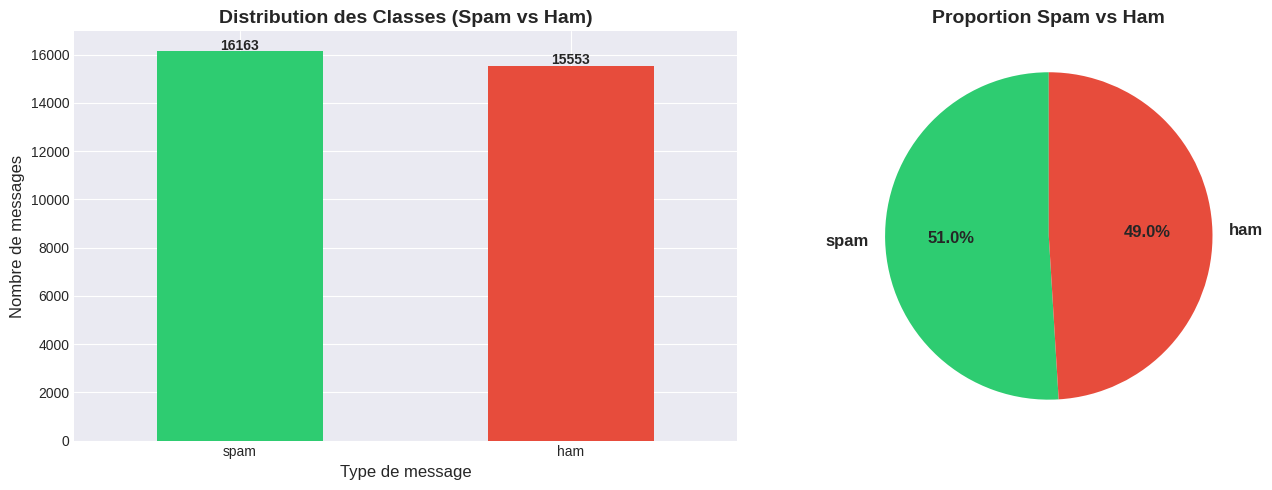


⚠️  Analyse du déséquilibre:
   Le dataset est relativement équilibré.


In [6]:
print("=" * 60)
print("DISTRIBUTION DE LA VARIABLE CIBLE")
print("=" * 60)

# Comptage
label_counts = df['label_text'].value_counts()
print(f"\nRépartition des classes:")
print(label_counts)
print(f"\nPourcentages:")
print(df['label_text'].value_counts(normalize=True) * 100)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres
label_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution des Classes (Spam vs Ham)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Type de message', fontsize=12)
axes[0].set_ylabel('Nombre de messages', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Ajout des valeurs sur les barres
for i, v in enumerate(label_counts):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Graphique circulaire
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Proportion Spam vs Ham', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Analyse du déséquilibre
spam_count = df[df['label'] == 1].shape[0]
ham_count = df[df['label'] == 0].shape[0]
spam_ratio = spam_count / len(df) * 100
ham_ratio = ham_count / len(df) * 100

print(f"\n⚠️  Analyse du déséquilibre:")
if spam_ratio < 20 or ham_ratio < 20:
    print(f"   Le dataset est déséquilibré (ratio spam: {spam_ratio:.1f}%, ham: {ham_ratio:.1f}%)")
    print(f"   Considérer l'utilisation de techniques de rééquilibrage si nécessaire.")
else:
    print(f"   Le dataset est relativement équilibré.")

## 3. Génération de WordClouds

### 3.1 WordCloud des emails Spam

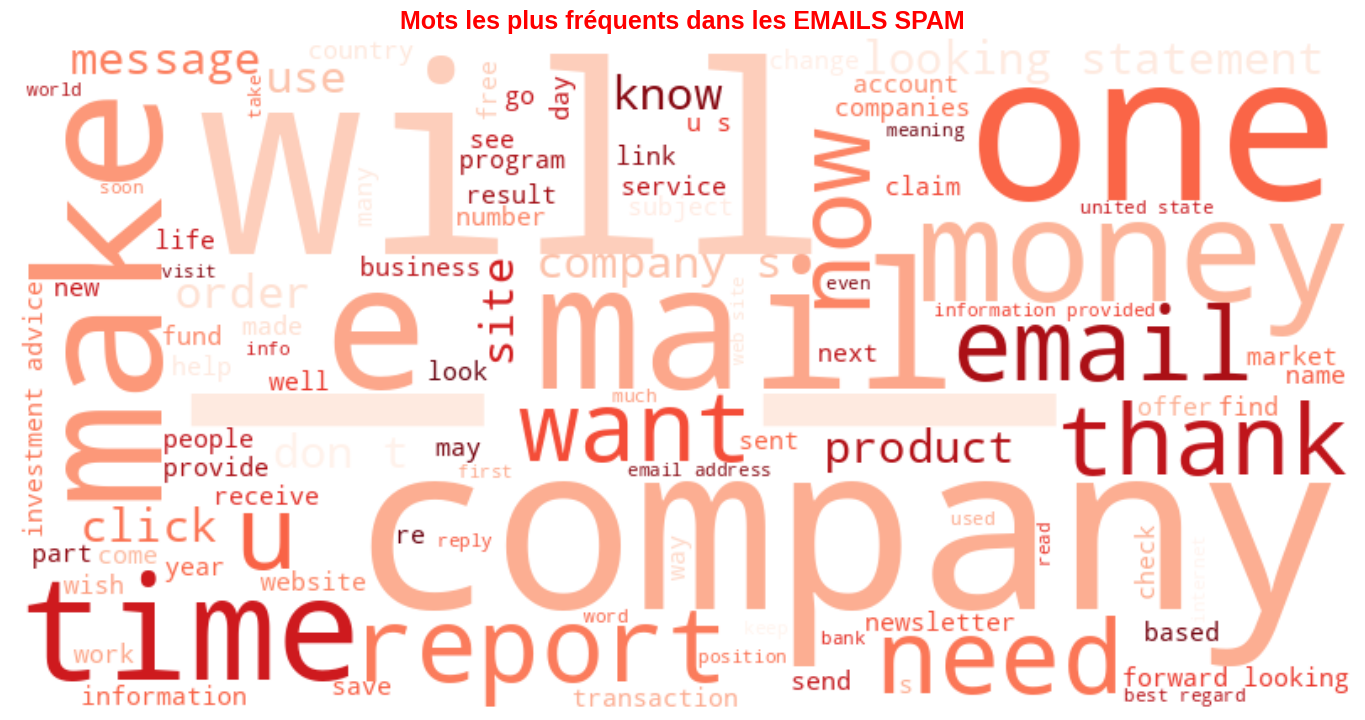


Nombre de mots dans les spam: 4236567


In [7]:
# Récupération de tous les textes spam
spam_text = ' '.join(df[df['label'] == 1]['text'].astype(str))

# Création du WordCloud
wordcloud_spam = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(spam_text)

# Visualisation
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Mots les plus fréquents dans les EMAILS SPAM', fontsize=18, fontweight='bold', color='red')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

print(f"\nNombre de mots dans les spam: {len(spam_text.split())}")

### 3.2 WordCloud des emails Ham (légitimes)

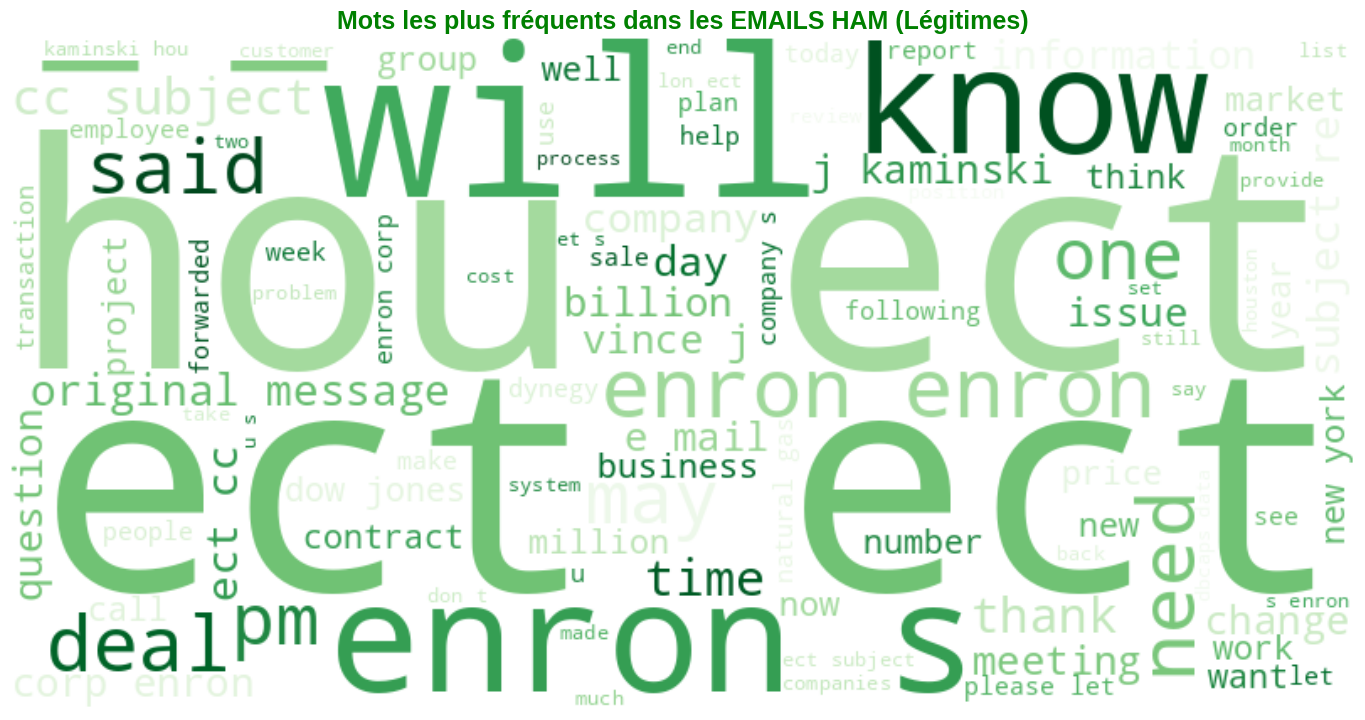


Nombre de mots dans les ham: 5627135


In [8]:
# Récupération de tous les textes ham
ham_text = ' '.join(df[df['label'] == 0]['text'].astype(str))

# Création du WordCloud
wordcloud_ham = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(ham_text)

# Visualisation
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Mots les plus fréquents dans les EMAILS HAM (Légitimes)', fontsize=18, fontweight='bold', color='green')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

print(f"\nNombre de mots dans les ham: {len(ham_text.split())}")

## 4. Prétraitement du Texte

### 4.1 Nettoyage initial

In [9]:
print("=" * 60)
print("NETTOYAGE INITIAL DES DONNÉES")
print("=" * 60)

# Afficher les dimensions avant nettoyage
print(f"\nDimensions avant nettoyage: {df.shape}")

# Conversion en minuscules
df['text'] = df['text'].str.lower()
print("✓ Conversion en minuscules effectuée")

# Suppression des lignes avec texte vide ou manquant
df = df[df['text'].notna()]
df = df[df['text'].str.strip() != '']
print("✓ Suppression des textes vides effectuée")

# Suppression des doublons basés sur le texte
duplicates_before = df.duplicated(subset=['text']).sum()
df = df.drop_duplicates(subset=['text'])
print(f"✓ {duplicates_before} doublons supprimés (basés sur le texte)")

# Reset de l'index
df = df.reset_index(drop=True)

print(f"\nDimensions après nettoyage: {df.shape}")

NETTOYAGE INITIAL DES DONNÉES

Dimensions avant nettoyage: (31716, 7)
✓ Conversion en minuscules effectuée
✓ Suppression des textes vides effectuée
✓ 2854 doublons supprimés (basés sur le texte)

Dimensions après nettoyage: (28811, 7)


### 4.2 Fonction de prétraitement complète

In [10]:
# Initialisation des outils NLP
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Fonction complète de prétraitement du texte:
    1. Suppression de la ponctuation et caractères spéciaux
    2. Tokenisation
    3. Suppression des stopwords
    4. Stemming
    """
    # 1. Suppression de la ponctuation et caractères spéciaux (garde seulement lettres et espaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 2. Tokenisation
    tokens = word_tokenize(text)
    
    # 3. Suppression des stopwords et stemming
    processed_tokens = [
        stemmer.stem(token) 
        for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    
    # Retour du texte nettoyé
    return ' '.join(processed_tokens)

print("Fonction de prétraitement créée!")
print("\nExemple de prétraitement:")
sample_text = df['text'].iloc[0]
print(f"\nTexte original: {sample_text[:200]}...")
print(f"\nTexte prétraité: {preprocess_text(sample_text)[:200]}...")

Fonction de prétraitement créée!

Exemple de prétraitement:

Texte original: any software just for 15 $ - 99 $ understanding oem software
lead me not into temptation ; i can find the way myself .
# 3533 . the law disregards trifles ....

Texte prétraité: softwar understand oem softwar lead temptat find way law disregard trifl...


### 4.3 Application du prétraitement sur tout le dataset

In [ ]:
print("Prétraitement du dataset en cours...")
print("Cette opération peut prendre quelques minutes...\n")

# Combiner subject et text
print("Combinaison du subject et du text...")
df['combined_text'] = df['subject'].fillna('') + ' ' + df['text'].fillna('')
print("✓ Subject et text combinés\n")

# Application du prétraitement sur le texte combiné
df['processed_text'] = df['combined_text'].apply(preprocess_text)

print("✓ Prétraitement terminé!\n")

# Affichage de quelques exemples
print("=" * 80)
print("EXEMPLES DE TEXTES AVANT/APRÈS PRÉTRAITEMENT")
print("=" * 80)

for i in range(min(3, len(df))):
    print(f"\nExemple {i+1} [{df['label_text'].iloc[i].upper()}]:")
    print(f"Original     : {df['combined_text'].iloc[i][:100]}...")
    print(f"Prétraité    : {df['processed_text'].iloc[i][:100]}...")
    print("-" * 80)

# Affichage du dataframe final
print("\nDataFrame final:")
df[['label', 'label_text', 'combined_text', 'processed_text']].head()

## 5. Vectorisation du Texte

In [12]:
print("=" * 60)
print("VECTORISATION DU TEXTE AVEC TF-IDF")
print("=" * 60)

# Préparation des données
X = df['processed_text']
y = df['label']  # Déjà numérique (0=ham, 1=spam)

print(f"\nNombre total de documents: {len(X)}")
print(f"Distribution des labels: {y.value_counts().to_dict()}")

# Initialisation du TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=3000,  # Nombre maximum de features
    min_df=2,           # Minimum de documents pour qu'un mot soit considéré
    max_df=0.8,         # Maximum de documents (évite les mots trop fréquents)
    ngram_range=(1, 2)  # Unigrammes et bigrammes
)

# Vectorisation
X_tfidf = tfidf.fit_transform(X)

print(f"\n✓ Vectorisation TF-IDF complétée!")
print(f"\nDimensions de la matrice TF-IDF: {X_tfidf.shape}")
print(f"Nombre de features (mots/n-grams): {X_tfidf.shape[1]}")
print(f"Sparsité de la matrice: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100:.2f}%")

# Top 20 mots les plus importants
feature_names = tfidf.get_feature_names_out()
print(f"\nExemples de features extraites (20 premiers):")
print(list(feature_names[:20]))

VECTORISATION DU TEXTE AVEC TF-IDF

Nombre total de documents: 28811
Distribution des labels: {0: 14982, 1: 13829}

✓ Vectorisation TF-IDF complétée!

Dimensions de la matrice TF-IDF: (28811, 3000)
Nombre de features (mots/n-grams): 3000
Sparsité de la matrice: 97.88%

Exemples de features extraites (20 premiers):
['abil', 'abl', 'absolut', 'abus', 'accept', 'accept term', 'access', 'accomplish', 'accord', 'account', 'account invest', 'accur', 'accuraci', 'accuraci complet', 'achiev', 'aci', 'aci est', 'acquir', 'acquisit', 'acrobat']


## 6. Division du Dataset

In [13]:
# Division en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintient la distribution des classes
)

print("=" * 60)
print("DIVISION DU DATASET")
print("=" * 60)
print(f"\nTaille de l'ensemble d'entraînement: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Taille de l'ensemble de test: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nDistribution dans l'ensemble d'entraînement:")
print(f"  Ham: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Spam: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\nDistribution dans l'ensemble de test:")
print(f"  Ham: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  Spam: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

DIVISION DU DATASET

Taille de l'ensemble d'entraînement: 23048 (80.0%)
Taille de l'ensemble de test: 5763 (20.0%)

Distribution dans l'ensemble d'entraînement:
  Ham: 11985 (52.0%)
  Spam: 11063 (48.0%)

Distribution dans l'ensemble de test:
  Ham: 2997 (52.0%)
  Spam: 2766 (48.0%)


## 7. Entraînement des Modèles

### 7.1 Définition des modèles

In [21]:
# Dictionnaire des modèles à tester
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

print("Modèles à entraîner:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i}. {model_name}")

Modèles à entraîner:
1. Naive Bayes
2. Logistic Regression
3. Random Forest
4. SVM
5. XGBoost


### 7.2 Entraînement et évaluation

In [22]:
# Dictionnaire pour stocker les résultats
results = {}

print("=" * 80)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES")
print("=" * 80)

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Modèle: {model_name}")
    print(f"{'='*80}")
    
    # Entraînement
    print("Entraînement en cours...")
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Stockage des résultats
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }
    
    # Affichage des résultats
    print(f"\n📊 Résultats:")
    print(f"   Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision : {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall    : {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-Score  : {f1:.4f} ({f1*100:.2f}%)")
    
    # Matrice de confusion
    print(f"\n📈 Matrice de confusion:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"   True Negatives  (Ham correctement classé)  : {cm[0][0]}")
    print(f"   False Positives (Ham classé comme Spam)     : {cm[0][1]}")
    print(f"   False Negatives (Spam classé comme Ham)     : {cm[1][0]}")
    print(f"   True Positives  (Spam correctement classé)  : {cm[1][1]}")

print(f"\n\n{'='*80}")
print("ENTRAÎNEMENT TERMINÉ!")
print(f"{'='*80}")

ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

Modèle: Naive Bayes
Entraînement en cours...

📊 Résultats:
   Accuracy  : 0.9766 (97.66%)
   Precision : 0.9744 (97.44%)
   Recall    : 0.9769 (97.69%)
   F1-Score  : 0.9756 (97.56%)

📈 Matrice de confusion:
[[2926   71]
 [  64 2702]]
   True Negatives  (Ham correctement classé)  : 2926
   False Positives (Ham classé comme Spam)     : 71
   False Negatives (Spam classé comme Ham)     : 64
   True Positives  (Spam correctement classé)  : 2702

Modèle: Logistic Regression
Entraînement en cours...

📊 Résultats:
   Accuracy  : 0.9826 (98.26%)
   Precision : 0.9757 (97.57%)
   Recall    : 0.9884 (98.84%)
   F1-Score  : 0.9820 (98.20%)

📈 Matrice de confusion:
[[2929   68]
 [  32 2734]]
   True Negatives  (Ham correctement classé)  : 2929
   False Positives (Ham classé comme Spam)     : 68
   False Negatives (Spam classé comme Ham)     : 32
   True Positives  (Spam correctement classé)  : 2734

Modèle: Random Forest
Entraînement en cours...

📊 Résultat

## 8. Comparaison des Modèles

COMPARAISON DES PERFORMANCES

               Model  Accuracy  Precision   Recall  F1-Score
                SVM  0.984904   0.978564 0.990239  0.984367
Logistic Regression  0.982648   0.975732 0.988431  0.982040
      Random Forest  0.981433   0.975671 0.985900  0.980759
            XGBoost  0.979525   0.966526 0.991685  0.978944
        Naive Bayes  0.976575   0.974396 0.976862  0.975627


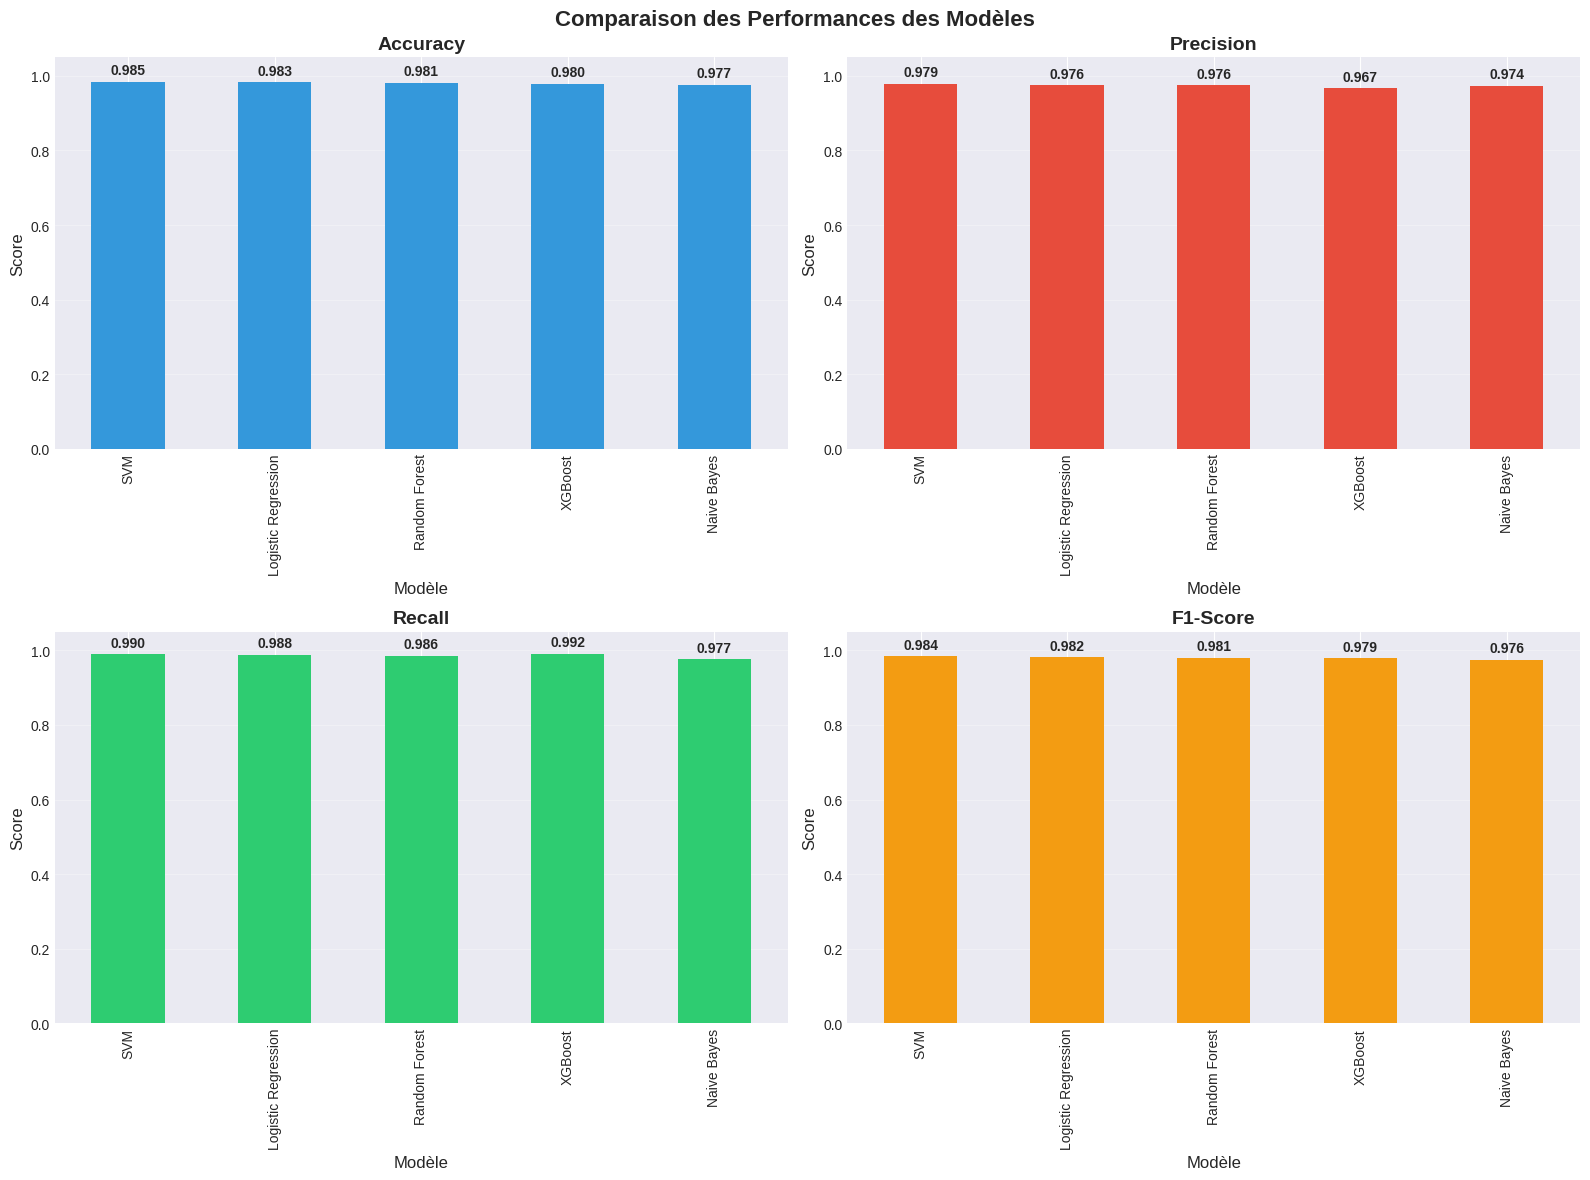


🏆 MEILLEUR MODÈLE: SVM
   F1-Score: 0.9844 (98.44%)
   Accuracy: 0.9849
   Precision: 0.9786
   Recall: 0.9902


In [23]:
# Création d'un DataFrame pour comparer les résultats
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})

# Tri par F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("=" * 80)
print("COMPARAISON DES PERFORMANCES")
print("=" * 80)
print("\n", comparison_df.to_string(index=False))

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison des Performances des Modèles', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, color=color, legend=False)
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Modèle', fontsize=12)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Identification du meilleur modèle
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f} ({best_f1*100:.2f}%)")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   Precision: {results[best_model_name]['precision']:.4f}")
print(f"   Recall: {results[best_model_name]['recall']:.4f}")

## 9. Analyse Détaillée du Meilleur Modèle

RAPPORT DE CLASSIFICATION - SVM

               precision    recall  f1-score   support

         Ham       0.99      0.98      0.99      2997
        Spam       0.98      0.99      0.98      2766

    accuracy                           0.98      5763
   macro avg       0.98      0.99      0.98      5763
weighted avg       0.98      0.98      0.98      5763



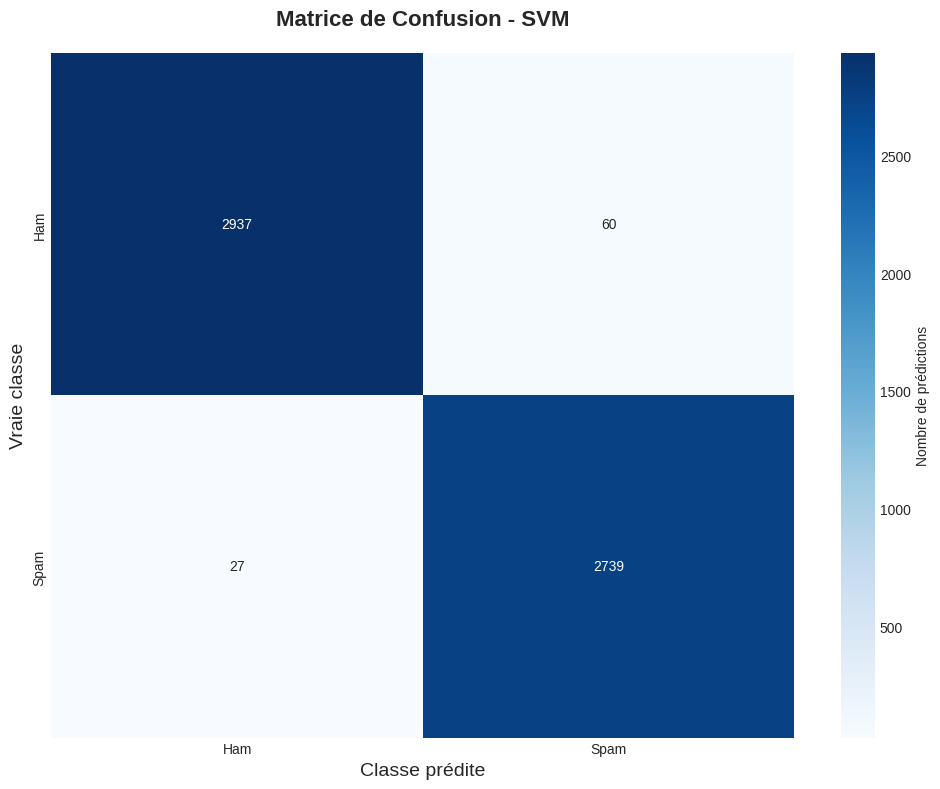


📊 Statistiques détaillées:
   True Negatives (TN)  : 2937 - Ham correctement identifiés
   False Positives (FP) : 60 - Ham incorrectement classés comme Spam
   False Negatives (FN) : 27 - Spam incorrectement classés comme Ham ⚠️
   True Positives (TP)  : 2739 - Spam correctement identifiés

   Taux de faux positifs: 2.00%
   Taux de faux négatifs: 0.98%


In [24]:
# Rapport de classification détaillé
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']

print("=" * 80)
print(f"RAPPORT DE CLASSIFICATION - {best_model_name}")
print("=" * 80)
print("\n", classification_report(y_test, y_pred_best, target_names=['Ham', 'Spam']))

# Matrice de confusion détaillée
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'],
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title(f'Matrice de Confusion - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Vraie classe', fontsize=14)
plt.xlabel('Classe prédite', fontsize=14)
plt.tight_layout()
plt.show()

# Statistiques détaillées
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Statistiques détaillées:")
print(f"   True Negatives (TN)  : {tn} - Ham correctement identifiés")
print(f"   False Positives (FP) : {fp} - Ham incorrectement classés comme Spam")
print(f"   False Negatives (FN) : {fn} - Spam incorrectement classés comme Ham ⚠️")
print(f"   True Positives (TP)  : {tp} - Spam correctement identifiés")
print(f"\n   Taux de faux positifs: {fp/(fp+tn)*100:.2f}%")
print(f"   Taux de faux négatifs: {fn/(fn+tp)*100:.2f}%")

## 10. Sauvegarde du Modèle

In [25]:
import os

# Création du dossier models s'il n'existe pas
os.makedirs('models', exist_ok=True)

# Sauvegarde du meilleur modèle
model_path = f'models/best_spam_detector_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_path)
print(f"✓ Modèle sauvegardé: {model_path}")

# Sauvegarde du vectorizer TF-IDF
vectorizer_path = 'models/tfidf_vectorizer.pkl'
joblib.dump(tfidf, vectorizer_path)
print(f"✓ Vectorizer sauvegardé: {vectorizer_path}")

# Sauvegarde des métadonnées
metadata = {
    'model_name': best_model_name,
    'accuracy': float(results[best_model_name]['accuracy']),
    'precision': float(results[best_model_name]['precision']),
    'recall': float(results[best_model_name]['recall']),
    'f1_score': float(results[best_model_name]['f1_score']),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_size': len(df)
}

import json
metadata_path = 'models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Métadonnées sauvegardées: {metadata_path}")

print("\n" + "="*80)
print("MODÈLE PRÊT POUR L'INTÉGRATION STREAMLIT")
print("="*80)
print(f"\nFichiers sauvegardés:")
print(f"  1. {model_path}")
print(f"  2. {vectorizer_path}")
print(f"  3. {metadata_path}")

✓ Modèle sauvegardé: models/best_spam_detector_svm.pkl
✓ Vectorizer sauvegardé: models/tfidf_vectorizer.pkl
✓ Métadonnées sauvegardées: models/model_metadata.json

MODÈLE PRÊT POUR L'INTÉGRATION STREAMLIT

Fichiers sauvegardés:
  1. models/best_spam_detector_svm.pkl
  2. models/tfidf_vectorizer.pkl
  3. models/model_metadata.json
